CROP RECOMMENDATION SYSTEM
Machine Learning for Agriculture
Dataset Shape: (28242, 8)

First few rows:
   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
3                         1485.0              121.0     16.37  
4                         1485.0              121.0     16.37  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-N

c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\uti

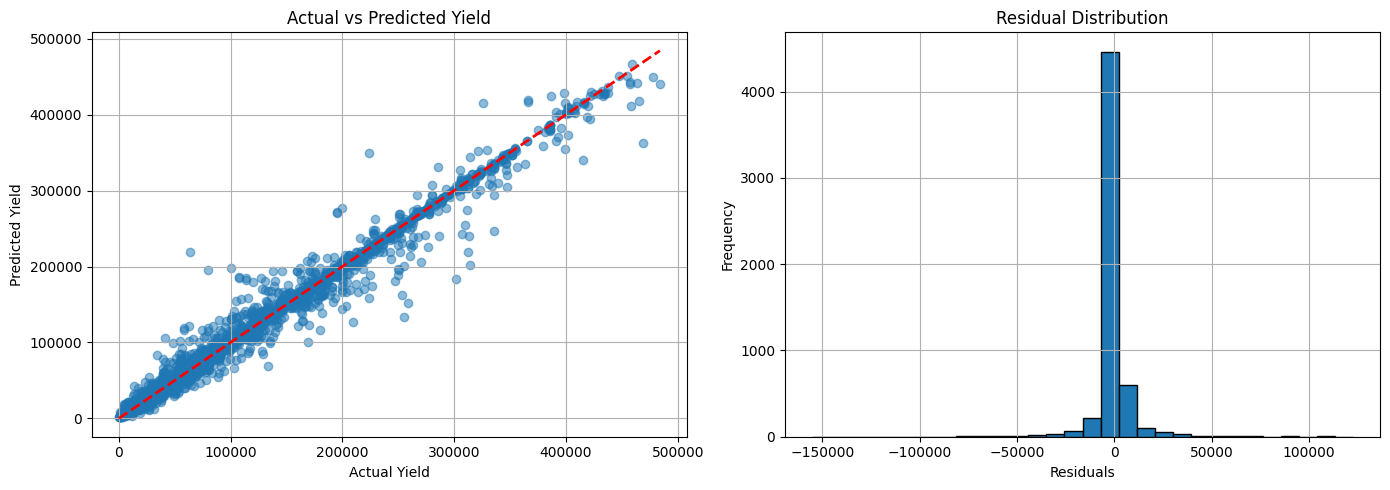

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class CropRecommendationSystem:
    def __init__(self):
        self.yield_model = None
        self.disease_model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}

    def load_data(self, filepath):
        df = pd.read_csv(filepath)
        print("Dataset Shape:", df.shape)
        print("\nFirst few rows:")
        print(df.head())
        print("\nDataset Info:")
        print(df.info())
        print("\nStatistical Summary:")
        print(df.describe())
        return df

    def preprocess_data(self, df):
        df_processed = df.copy()

        if 'Area' in df_processed.columns:
            self.label_encoders['Area'] = LabelEncoder()
            df_processed['Area_encoded'] = self.label_encoders['Area'].fit_transform(df_processed['Area'])

        if 'Item' in df_processed.columns:
            self.label_encoders['Item'] = LabelEncoder()
            df_processed['Item_encoded'] = self.label_encoders['Item'].fit_transform(df_processed['Item'])

        print("\nEncoded Categories:")
        if 'Area' in df_processed.columns:
            print("Areas:", dict(enumerate(self.label_encoders['Area'].classes_)))
        if 'Item' in df_processed.columns:
            print("Items:", dict(enumerate(self.label_encoders['Item'].classes_)))

        return df_processed

    def train_yield_prediction(self, df):
        print("\n" + "="*60)
        print("TRAINING YIELD PREDICTION MODEL")
        print("="*60)

        feature_cols = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
        if 'Area_encoded' in df.columns:
            feature_cols.append('Area_encoded')
        if 'Item_encoded' in df.columns:
            feature_cols.append('Item_encoded')

        X = df[feature_cols]
        y = df['hg/ha_yield']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.yield_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.yield_model.fit(X_train_scaled, y_train)

        y_pred = self.yield_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(f"\nYield Prediction Results:")
        print(f"RMSE: {rmse:.2f}")
        print(f"R² Score: {r2:.4f}")

        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': self.yield_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nFeature Importance:")
        print(feature_importance)

        return X_test_scaled, y_test, y_pred

    def create_disease_labels(self, df):
        conditions = [
            (df['hg/ha_yield'] < df['hg/ha_yield'].quantile(0.25)),
            (df['hg/ha_yield'] >= df['hg/ha_yield'].quantile(0.25)) &
            (df['hg/ha_yield'] < df['hg/ha_yield'].quantile(0.75)),
            (df['hg/ha_yield'] >= df['hg/ha_yield'].quantile(0.75))
        ]
        labels = ['High Risk', 'Medium Risk', 'Low Risk']
        df['disease_risk'] = np.select(conditions, labels, default='Unknown Risk') # Added default string value
        return df

    def train_disease_detection(self, df):
        print("\n" + "="*60)
        print("TRAINING DISEASE DETECTION MODEL")
        print("="*60)

        df = self.create_disease_labels(df)

        feature_cols = ['Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
        if 'Area_encoded' in df.columns:
            feature_cols.append('Area_encoded')
        if 'Item_encoded' in df.columns:
            feature_cols.append('Item_encoded')

        X = df[feature_cols]
        y = df['disease_risk']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        self.disease_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        self.disease_model.fit(X_train, y_train)

        y_pred = self.disease_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)

        print(f"\nDisease Detection Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        return X_test, y_test, y_pred

    def recommend_crop(self, area, year, rainfall, pesticides, avg_temp):
        print("\n" + "="*60)
        print("CROP RECOMMENDATION")
        print("="*60)

        recommendations = []

        area_encoded = self.label_encoders['Area'].transform([area])[0]

        for item in self.label_encoders['Item'].classes_:
            item_encoded = self.label_encoders['Item'].transform([item])[0]

            features = np.array([[year, rainfall, pesticides, avg_temp, area_encoded, item_encoded]])
            features_scaled = self.scaler.transform(features)

            predicted_yield = self.yield_model.predict(features_scaled)[0]

            disease_features = np.array([[year, predicted_yield, rainfall, pesticides, avg_temp, area_encoded, item_encoded]])
            disease_risk = self.disease_model.predict(disease_features)[0]

            recommendations.append({
                'Crop': item,
                'Predicted_Yield': predicted_yield,
                'Disease_Risk': disease_risk
            })

        recommendations_df = pd.DataFrame(recommendations)
        recommendations_df = recommendations_df.sort_values('Predicted_Yield', ascending=False)

        print(f"\nRecommendations for {area} in {year}:")
        print(f"Rainfall: {rainfall} mm/year")
        print(f"Pesticides: {pesticides} tonnes")
        print(f"Temperature: {avg_temp}°C")
        print("\n" + recommendations_df.to_string(index=False))

        return recommendations_df

    def visualize_results(self, y_test, y_pred):
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].scatter(y_test, y_pred, alpha=0.5)
        axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual Yield')
        axes[0].set_ylabel('Predicted Yield')
        axes[0].set_title('Actual vs Predicted Yield')
        axes[0].grid(True)

        residuals = y_test - y_pred
        axes[1].hist(residuals, bins=30, edgecolor='black')
        axes[1].set_xlabel('Residuals')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Residual Distribution')
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig('yield_prediction_results.png')
        print("\nVisualization saved as 'yield_prediction_results.png'")

def main():
    print("="*60)
    print("CROP RECOMMENDATION SYSTEM")
    print("Machine Learning for Agriculture")
    print("="*60)

    system = CropRecommendationSystem()

    df = system.load_data('RS-A1_yield.csv')

    df_processed = system.preprocess_data(df)

    X_test, y_test, y_pred = system.train_yield_prediction(df_processed)

    X_test_disease, y_test_disease, y_pred_disease = system.train_disease_detection(df_processed)

    system.visualize_results(y_test, y_pred)

    recommendations = system.recommend_crop(
        area='Albania',
        year=1992,
        rainfall=1485,
        pesticides=121,
        avg_temp=16.0
    )

    print("\n" + "="*60)
    print("SYSTEM TRAINING COMPLETE")
    print("="*60)

if __name__ == "__main__":
    main()

# Deep Dive: Concepts, Math, and Code Walkthrough

> This section explains the learning tasks, models, metrics, and how each function in this notebook fits together, with key formulas.

## Data preprocessing
- Label Encoding maps strings to integers: `Area → Area_encoded`, `Item → Item_encoded`.
- Standardization for a feature x: $z = \dfrac{x - \mu}{\sigma}$ (mean $\mu$, std $\sigma$).
- Train/Test Split: 80/20 with fixed `random_state` to ensure reproducibility.

## Yield prediction (Regression)
Model: Random Forest Regressor (RF) — an ensemble of decision trees trained on bootstrapped samples.
- Tree split criterion (e.g., MSE reduction):
  - At a node with target values $\{y_i\}$, impurity $I = \dfrac{1}{n}\sum_i (y_i - \bar y)^2$.
  - A split S yields gain $\Delta I = I_{parent} - \Big( \tfrac{n_L}{n} I_L + \tfrac{n_R}{n} I_R \Big)$.
- RF prediction is the average of T tree predictions:
  $$\hat y(x) = \frac{1}{T} \sum_{t=1}^{T} h_t(x).$$
- Feature importance (Gini/variance reduction): average impurity decrease contributed by a feature across trees.

Evaluation metrics:
- Mean Squared Error: $\text{MSE} = \dfrac{1}{n}\sum_{i=1}^n (y_i - \hat y_i)^2$.
- Root MSE: $\text{RMSE} = \sqrt{\text{MSE}}$.
- Coefficient of Determination: $R^2 = 1 - \dfrac{\sum (y_i-\hat y_i)^2}{\sum (y_i-\bar y)^2}$.

Code mapping:
- `train_yield_prediction(df)` builds features [Year, rainfall, pesticides, avg_temp, Area_encoded, Item_encoded], scales them, fits RF, prints RMSE and R², and returns test predictions.

## Disease risk (Classification)
- We engineer `disease_risk` labels from yield quantiles (25%/75%).
- Gradient Boosting Classifier builds an additive model:
  $$F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x),$$
  where $h_m$ is a shallow tree fitted to the negative gradient of the loss (the residuals), and $\nu$ is the learning rate.
- For multi-class classification, boosting optimizes a differentiable loss (e.g., logistic).

Classification metrics:
- Accuracy: $\dfrac{TP + TN}{TP + TN + FP + FN}$.
- Precision (per class): $\dfrac{TP}{TP + FP}$.
- Recall (per class): $\dfrac{TP}{TP + FN}$.
- F1: $2\cdot\dfrac{\text{Precision}\cdot\text{Recall}}{\text{Precision}+\text{Recall}}$.

Code mapping:
- `create_disease_labels(df)`: computes risk from yield quantiles.
- `train_disease_detection(df)`: fits GradientBoostingClassifier and prints accuracy + classification report.

## Recommendations
To recommend crops for an Area and Year:
1) Encode `(Area, Item)` to numeric features; collect environmental attributes.
2) Scale and predict yield: $\hat y$ via RF.
3) Form disease features (including $\hat y$) and predict `disease_risk` via GB.
4) Repeat over all Items (crops), then sort by highest $\hat y$.

Code mapping:
- `recommend_crop(area, year, rainfall, pesticides, avg_temp)`: loops over all Items, predicts yield and risk, returns a ranked DataFrame.
- Menu (Cell 2): assists with selecting Area/Item/Year, auto-filling sensible defaults from medians, and displays ranked results.

## Edge cases and tips
- If Area/Item not seen in training, LabelEncoder will fail — use only known categories (menu lists valid values).
- When Year or attributes are far from training distribution, expect larger residuals.
- You can adjust RF `n_estimators` and GB hyperparameters to trade speed vs accuracy.

# Crop Disease Detection & Yield Prediction — Overview

> This notebook builds an end‑to‑end ML pipeline for agriculture: data prep, yield regression, disease classification, model evaluation, visualizations, and an interactive menu for recommendations.

## What you’ll find here
- Data loading and inspection from `RS-A1_yield.csv`
- Preprocessing with Label Encoding and Standardization
- Yield prediction using Random Forest Regressor
- Disease risk classification using Gradient Boosting
- Evaluation metrics (RMSE, R², Accuracy, Classification Report)
- Visualizations (Actual vs Predicted, Residuals)
- Interactive Menu (Cell 2): choose Area/Item/Year and attributes to get ranked crop recommendations

## Quick pipeline
1. Load CSV and explore schema, stats, and missing values
2. Encode categorical features: Area, Item
3. Train Random Forest for yield; compute feature importance
4. Derive disease_risk labels from yield quantiles
5. Train Gradient Boosting for disease detection
6. Visualize results and residuals
7. Use `recommend_crop(...)` and the menu to get ranked crops

## Inputs and outputs
- Inputs: Area, Item, Year, average_rain_fall_mm_per_year, pesticides_tonnes, avg_temp
- Outputs:
  - Predicted yield for each crop (hg/ha)
  - Disease risk class per crop (High/Medium/Low)
  - Ranked recommendations (highest yield first)

## Interactive use
- Run Cell 1 to define the `CropRecommendationSystem` and train models
- Run Cell 2 to launch the menu (auto‑starts)
- Optionally, call `recommend_crop()` directly with parameters

## Notes
- Defaults for rainfall/pesticides/temp come from dataset medians matching Area+Year (fallbacks to Area, then global)
- Models and scalers are kept inside `CropRecommendationSystem`
- You can switch the default Area/Year in the menu prompts easily

In [5]:
import sys
from difflib import get_close_matches
from IPython.display import display

# Ensure CropRecommendationSystem is available (from Cell 1 or fallback to module)
try:

    CropRecommendationSystem  # type: ignore[name-defined]
except NameError:  # If Cell 1 wasn't executed
    from rs_a1 import CropRecommendationSystem

# This cell adds an interactive, menu-driven interface that asks the user for
# Area, Item, Year and necessary attributes, then prints recommendations.

DATA_PATH = 'RS-A1_yield.csv'


def _get_defaults(df, area, year):
    """Heuristics to fill rainfall, pesticides, avg_temp from dataset medians.
    Priority: (area & year) -> (area only) -> (global median)
    """
    import pandas as pd
    cols = ['average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
    subset = df[(df['Area'] == area) & (df['Year'] == year)]
    if subset.empty:
        subset = df[df['Area'] == area]
    if subset.empty:
        subset = df
    med = subset[cols].median(numeric_only=True)
    return float(med['average_rain_fall_mm_per_year']), float(med['pesticides_tonnes']), float(med['avg_temp'])


def _prompt_with_default(prompt, default_value, caster=float):
    while True:
        raw = input(f"{prompt} [{default_value}]: ").strip()
        if raw == '':
            return caster(default_value)
        try:
            return caster(raw)
        except Exception:
            print("Invalid input. Please enter a valid value or press Enter for default.")


def _print_numbered(title, values, max_show=30):
    print(f"\n{title} (total {len(values)})")
    print("-"*60)
    n = min(len(values), max_show)
    for i in range(n):
        print(f"{i+1:>3}. {values[i]}")
    if len(values) > max_show:
        print(f"... ({len(values) - max_show} more; type name or index)")


def _choose_name_or_index(name, options):
    lookup = {o.lower(): o for o in options}
    while True:
        raw = input(f"Enter {name} (name or number 1-{len(options)}): ").strip()
        if raw.isdigit():
            k = int(raw)
            if 1 <= k <= len(options):
                return options[k-1]
            print(f"Please enter a number between 1 and {len(options)}.")
            continue
        val = lookup.get(raw.lower())
        if val:
            return val
        matches = get_close_matches(raw.lower(), list(lookup.keys()), n=5, cutoff=0.6)
        if matches:
            print("Did you mean:", ", ".join(lookup[m] for m in matches))
        else:
            print(f"'{raw}' not found. Try again or use an index.")


def run_menu():
    import pandas as pd

    print("="*60)
    print("INTERACTIVE CROP RECOMMENDATION MENU")
    print("="*60)

    # Load data quietly
    try:
        df = pd.read_csv(DATA_PATH)
    except FileNotFoundError:
        print(f"Data file not found: {DATA_PATH}")
        return

    # Build system from class in Cell 1 / fallback import
    system = CropRecommendationSystem()

    # Preprocess and train once
    df_processed = system.preprocess_data(df)
    system.train_yield_prediction(df_processed)
    system.train_disease_detection(df_processed)

    areas = list(system.label_encoders['Area'].classes_)
    items = list(system.label_encoders['Item'].classes_)

    while True:
        print("\n" + "-"*60)
        print("Choose an option:")
        print("  1) Recommend top crops for an Area")
        print("  2) Predict for a specific Area + Item")
        print("  3) Exit menu")
        choice = input("Enter choice [1-3]: ").strip() or '1'

        if choice == '1':
            try:
                _print_numbered("Available Areas", areas)
                area = _choose_name_or_index("Area", areas)
                year = _prompt_with_default("Enter Year", int(df['Year'].median()), int)

                r_d, p_d, t_d = _get_defaults(df, area, year)
                print("\nProvide attributes (press Enter to accept defaults):")
                rainfall = _prompt_with_default("Average rainfall (mm/year)", r_d, float)
                pesticides = _prompt_with_default("Pesticides (tonnes)", p_d, float)
                avg_temp = _prompt_with_default("Average temperature (°C)", t_d, float)

                try:
                    top_n = int(input("Top N crops to display [5]: ").strip() or 5)
                    if top_n <= 0:
                        top_n = 5
                except Exception:
                    top_n = 5

                recs = system.recommend_crop(area, year, rainfall, pesticides, avg_temp)
                if hasattr(recs, 'head'):
                    display(recs.head(top_n))
                else:
                    print(recs)
            except KeyboardInterrupt:
                print("\nCancelled.")
        elif choice == '2':
            try:
                _print_numbered("Available Areas", areas)
                area = _choose_name_or_index("Area", areas)

                _print_numbered("Available Items", items)
                item = _choose_name_or_index("Item", items)

                year = _prompt_with_default("Enter Year", int(df['Year'].median()), int)
                r_d, p_d, t_d = _get_defaults(df, area, year)
                print("\nProvide attributes (press Enter to accept defaults):")
                rainfall = _prompt_with_default("Average rainfall (mm/year)", r_d, float)
                pesticides = _prompt_with_default("Pesticides (tonnes)", p_d, float)
                avg_temp = _prompt_with_default("Average temperature (°C)", t_d, float)

                recs = system.recommend_crop(area, year, rainfall, pesticides, avg_temp)
                if hasattr(recs, 'loc'):
                    row = recs.loc[recs['Crop'] == item]
                    if not row.empty:
                        display(row)
                    else:
                        print("Selected crop not found in predictions.")
                else:
                    print(recs)
            except KeyboardInterrupt:
                print("\nCancelled.")
        elif choice == '3':
            print("Exiting menu.")
            break
        else:
            print("Invalid choice. Please select 1, 2, or 3.")

run_menu()


INTERACTIVE CROP RECOMMENDATION MENU

Encoded Categories:
Areas: {0: 'Albania', 1: 'Algeria', 2: 'Angola', 3: 'Argentina', 4: 'Armenia', 5: 'Australia', 6: 'Austria', 7: 'Azerbaijan', 8: 'Bahamas', 9: 'Bahrain', 10: 'Bangladesh', 11: 'Belarus', 12: 'Belgium', 13: 'Botswana', 14: 'Brazil', 15: 'Bulgaria', 16: 'Burkina Faso', 17: 'Burundi', 18: 'Cameroon', 19: 'Canada', 20: 'Central African Republic', 21: 'Chile', 22: 'Colombia', 23: 'Croatia', 24: 'Denmark', 25: 'Dominican Republic', 26: 'Ecuador', 27: 'Egypt', 28: 'El Salvador', 29: 'Eritrea', 30: 'Estonia', 31: 'Finland', 32: 'France', 33: 'Germany', 34: 'Ghana', 35: 'Greece', 36: 'Guatemala', 37: 'Guinea', 38: 'Guyana', 39: 'Haiti', 40: 'Honduras', 41: 'Hungary', 42: 'India', 43: 'Indonesia', 44: 'Iraq', 45: 'Ireland', 46: 'Italy', 47: 'Jamaica', 48: 'Japan', 49: 'Kazakhstan', 50: 'Kenya', 51: 'Latvia', 52: 'Lebanon', 53: 'Lesotho', 54: 'Libya', 55: 'Lithuania', 56: 'Madagascar', 57: 'Malawi', 58: 'Malaysia', 59: 'Mali', 60: 'Maurita

c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\uti

,Crop,Predicted_Yield,Disease_Risk
3,Potatoes,224647.45,Low Risk
7,Sweet potatoes,155708.63,Low Risk
9,Yams,134639.90,Low Risk
2,Plantains and others,128241.74,Low Risk
0,Cassava,75145.60,Medium Risk
4,"Rice, paddy",52254.39,Medium Risk
1,Maize,34598.30,Medium Risk



------------------------------------------------------------
Choose an option:
  1) Recommend top crops for an Area
  2) Predict for a specific Area + Item
  3) Exit menu

Available Areas (total 101)
------------------------------------------------------------
  1. Albania
  2. Algeria
  3. Angola
  4. Argentina
  5. Armenia
  6. Australia
  7. Austria
  8. Azerbaijan
  9. Bahamas
 10. Bahrain
 11. Bangladesh
 12. Belarus
 13. Belgium
 14. Botswana
 15. Brazil
 16. Bulgaria
 17. Burkina Faso
 18. Burundi
 19. Cameroon
 20. Canada
 21. Central African Republic
 22. Chile
 23. Colombia
 24. Croatia
 25. Denmark
 26. Dominican Republic
 27. Ecuador
 28. Egypt
 29. El Salvador
 30. Eritrea
... (71 more; type name or index)

Available Areas (total 101)
------------------------------------------------------------
  1. Albania
  2. Algeria
  3. Angola
  4. Argentina
  5. Armenia
  6. Australia
  7. Austria
  8. Azerbaijan
  9. Bahamas
 10. Bahrain
 11. Bangladesh
 12. Belarus
 13. Belgium
 1

c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\sweta\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\uti

,Crop,Predicted_Yield,Disease_Risk
0,Cassava,75145.6,Medium Risk



------------------------------------------------------------
Choose an option:
  1) Recommend top crops for an Area
  2) Predict for a specific Area + Item
  3) Exit menu
Exiting menu.
Exiting menu.


In [ ]:
"""
================================================================================
CROP DISEASE DETECTION & YIELD PREDICTION SYSTEM
Machine Learning Concepts and Implementation
================================================================================

KEY CONCEPTS USED:

1. SUPERVISED LEARNING:
   - Learning from labeled data (we have input features and known outputs)
   - Two types used here:
     a) Regression: Predicting continuous values (yield in hg/ha)
     b) Classification: Predicting categories (disease risk levels)

2. RANDOM FOREST REGRESSOR:
   - Ensemble method: Combines multiple decision trees
   - Each tree is trained on random subset of data (bootstrap sampling)
   - Final prediction = average of all trees
   - Advantages: Reduces overfitting, handles non-linear relationships
   - Parameters:
     * n_estimators: Number of trees in forest (more trees = better but slower)
     * random_state: Seed for reproducibility

3. GRADIENT BOOSTING CLASSIFIER:
   - Sequential ensemble method: Trees built one after another
   - Each new tree corrects errors of previous trees
   - Uses gradient descent to minimize loss function
   - Better for classification tasks with multiple classes
   - Advantages: High accuracy, handles complex patterns

4. LABEL ENCODING:
   - Converts categorical text data into numerical format
   - Example: 'Albania' → 0, 'Algeria' → 1, etc.
   - ML models need numbers, not text
   - Each unique category gets a unique integer

5. STANDARD SCALER (FEATURE SCALING):
   - Normalizes features to have mean=0 and std=1
   - Formula: z = (x - mean) / std_deviation
   - Why needed: Different features have different scales
     * Year: 1990-2020
     * Rainfall: 100-3000 mm
     * Temperature: 5-35°C
   - Prevents features with larger values from dominating the model

6. TRAIN-TEST SPLIT:
   - Divides data into training (80%) and testing (20%) sets
   - Training set: Used to teach the model
   - Testing set: Used to evaluate model on unseen data
   - Prevents overfitting and checks generalization

7. EVALUATION METRICS:

   For REGRESSION (Yield Prediction):
   a) MSE (Mean Squared Error): Average of squared differences
      - Formula: MSE = Σ(actual - predicted)² / n
      - Lower is better

   b) RMSE (Root Mean Squared Error): Square root of MSE
      - Formula: RMSE = √MSE
      - Same units as target variable
      - Easier to interpret than MSE

   c) R² Score (Coefficient of Determination):
      - Measures how well model explains variance in data
      - Range: 0 to 1 (can be negative for bad models)
      - R² = 1: Perfect prediction
      - R² = 0.8+: Good model
      - R² = 0: Model no better than average

   For CLASSIFICATION (Disease Detection):
   a) Accuracy: Percentage of correct predictions
      - Formula: (Correct Predictions / Total Predictions) × 100

   b) Precision: Of predicted positives, how many are actually positive
      - Formula: True Positives / (True Positives + False Positives)

   c) Recall: Of actual positives, how many did we predict
      - Formula: True Positives / (True Positives + False Negatives)

   d) F1-Score: Harmonic mean of precision and recall
      - Formula: 2 × (Precision × Recall) / (Precision + Recall)

8. FEATURE IMPORTANCE:
   - Shows which features contribute most to predictions
   - In Random Forest: Based on reduction in impurity
   - Helps understand what drives yield predictions
   - Example: Temperature might be more important than pesticides

9. CONFUSION MATRIX CONCEPTS:
   - True Positive (TP): Correctly predicted positive class
   - True Negative (TN): Correctly predicted negative class
   - False Positive (FP): Incorrectly predicted positive (Type I error)
   - False Negative (FN): Incorrectly predicted negative (Type II error)

10. CROSS-VALIDATION CONCEPT (not implemented but important):
    - Multiple train-test splits to get robust performance estimate
    - K-Fold: Data divided into k parts, each part used as test once
    - Reduces variance in performance estimates

11. OVERFITTING vs UNDERFITTING:
    - Overfitting: Model memorizes training data, fails on new data
      * High training accuracy, low test accuracy
      * Solution: More data, simpler model, regularization

    - Underfitting: Model too simple to capture patterns
      * Low training accuracy, low test accuracy
      * Solution: More complex model, more features

12. FEATURE ENGINEERING:
    - Creating new features from existing ones
    - Here: Creating 'disease_risk' categories from yield values
    - Using quantiles (25%, 75%) to define risk levels

13. RECOMMENDATION SYSTEM LOGIC:
    - For each crop type:
      1. Predict expected yield
      2. Predict disease risk based on yield
      3. Rank crops by predicted yield
    - Helps farmers choose best crop for their conditions

14. RESIDUALS:
    - Difference between actual and predicted values
    - Residual = Actual - Predicted
    - Ideally: Should be randomly distributed around 0
    - Pattern in residuals = model missing something

15. BIAS-VARIANCE TRADEOFF:
    - Bias: Error from wrong assumptions (underfitting)
    - Variance: Error from sensitivity to training data (overfitting)
    - Goal: Balance both for optimal performance

================================================================================

"""
"""
        Train Random Forest model to predict crop yield

        Process:
        1. SELECT FEATURES (X): Input variables that influence yield
           - Year, rainfall, pesticides, temperature, area, crop type

        2. SELECT TARGET (y): What we want to predict
           - hg/ha_yield (crop yield in hectograms per hectare)

        3. TRAIN-TEST SPLIT: Divide data
           - 80% training: Teach the model
           - 20% testing: Evaluate on unseen data
           - random_state=42: Ensures same split every time (reproducibility)

        4. FEATURE SCALING: Normalize all features
           - Brings all features to same scale (mean=0, std=1)
           - Prevents large-valued features from dominating
           - Example: Year (1990) vs Rainfall (1500) - very different scales

        5. TRAIN MODEL: Random Forest learns patterns
           - Creates 100 decision trees
           - Each tree trained on random subset of data
           - Final prediction = average of all trees

        6. EVALUATE: Test on unseen data
           - RMSE: Average prediction error in same units as yield
           - R²: How much variance in data is explained (0-1 scale)

        7. FEATURE IMPORTANCE: Which factors matter most
           - Shows contribution of each feature to predictions
           - Helps understand what drives crop yield
        """
"""
        Create disease risk categories from yield data

        Logic:
        - Low yield → High disease risk (crop not doing well)
        - Medium yield → Medium disease risk
        - High yield → Low disease risk (healthy crop)

        Method: Using Quantiles (Percentiles)
        - 25th percentile: Bottom 25% of yields = High Risk
        - 25th to 75th percentile: Middle 50% = Medium Risk
        - 75th percentile+: Top 25% of yields = Low Risk

        This is FEATURE ENGINEERING: Creating new meaningful features
        """
"""
        Train Gradient Boosting model to classify disease risk

        Process:
        1. CREATE LABELS: Convert yield to risk categories
           - Classification needs discrete classes

        2. SELECT FEATURES: Include yield as it indicates plant health
           - All environmental factors + predicted/actual yield

        3. GRADIENT BOOSTING CLASSIFIER:
           - Sequential ensemble: Builds trees one by one
           - Each tree corrects mistakes of previous trees
           - Uses gradient descent optimization
           - Better than Random Forest for classification

        4. EVALUATION METRICS:
           - Accuracy: Overall correctness percentage
           - Precision: Of predicted High Risk, how many actually High Risk
           - Recall: Of actual High Risk, how many we caught
           - F1-Score: Balance between precision and recall

        5. CLASSIFICATION REPORT:
           - Shows per-class performance
           - Support: Number of samples in each class
        """
"""
        Recommend best crops for given conditions

        Algorithm:
        1. For each crop type:
           a) Encode area and crop name to numbers
           b) Create feature vector with all inputs
           c) Scale features using trained scaler
           d) Predict yield using trained model
           e) Predict disease risk based on predicted yield

        2. Collect all predictions in list

        3. Sort by predicted yield (highest to lowest)
           - Farmers want crops with highest expected yield
           - Also show disease risk for informed decision

        4. Display ranked recommendations

        Real-world usage:
        - Farmer inputs: location, year, available resources
        - System outputs: Best crops to plant with expected results
        - Helps optimize farming decisions
        """
"""
        Create visualizations to understand model performance

        Graph 1: Actual vs Predicted Yield
        - X-axis: True yield values from dataset
        - Y-axis: Model's predicted values
        - Red line: Perfect prediction (actual = predicted)
        - Points near line = good predictions
        - Points far from line = errors
        - Helps visually assess model accuracy

        Graph 2: Residual Distribution
        - Residuals = Actual - Predicted (errors)
        - Histogram shows distribution of errors
        - Should be bell-shaped (normal distribution)
        - Centered at 0 = unbiased model
        - Narrow distribution = small errors
        - Wide distribution = large errors

        """
"""
    Main execution function - Complete ML Pipeline

    PIPELINE STAGES:

    1. DATA LOADING:
       - Read CSV file into memory
       - Understand data structure and statistics

    2. PREPROCESSING:
       - Convert text to numbers (Label Encoding)
       - Prepare data for ML algorithms

    3. MODEL TRAINING:
       - Train Regression model for yield prediction
       - Train Classification model for disease detection
       - Learn patterns from historical data

    4. MODEL EVALUATION:
       - Test on unseen data (20% holdout)
       - Calculate performance metrics
       - Ensure model generalizes well

    5. VISUALIZATION:
       - Create graphs to understand performance
       - Visual proof of model accuracy

    6. RECOMMENDATION:
       - Use trained models for real predictions
       - Provide actionable insights for farmers

    WORKFLOW:
    Training Phase → Evaluation Phase → Deployment Phase

    KEY POINTS FOR EXAM:
    - Complete end-to-end ML system
    - Combines regression and classification
    - Real-world agricultural application
    - Interpretable results with visualizations
    - Scalable to new data and conditions
    """
